In [43]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import sys
import os
import glob
import numpy as np
import pandas as pd
import dask.dataframe as dd
import xarray as xr
import hvplot.xarray  # noqa
import seaborn as sns
from dask import delayed, compute
import itertools
from pytmatrix import tmatrix_aux, refractive, tmatrix, radar
from pymiecoated import Mie
from scipy.constants import c
from scipy import stats as ss
from scipy.optimize import minimize
from scipy.optimize import brentq
from scipy.special import gamma
from sqlalchemy.exc import OperationalError
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from re import split
import matplotlib.dates as mdates
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import matplotlib.pylab as pl
from dask import delayed, compute
from metpy.calc import pressure_to_height_std as p2h
from metpy.calc import lcl
import cartopy.crs as ccrs
import cartopy
import cartopy.mpl.ticker as cticker
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import warnings
import cython
warnings.filterwarnings('ignore')


sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini, make_dir

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(file_name='loc')[location]['path_data']

In [2]:
def norm_gamma(d, nw, mu, dm):
    f_mu = (6 * (4 + mu) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4) )
    slope = (4 + mu) / dm
    return nw * f_mu * (d / dm) ** mu * np.exp(-slope * d)

In [3]:
cluster = SLURMCluster(queue="seseml",
                       memory='50GB',
                       cores=40,
                       processes=1,
                       walltime='24:00:00', 
#                        scheduler_options={
#                            'host': '172.22.179.3:7224', 
#                            'dashboard_address': ':7798'
#                        }
                      )

cluster.scale(jobs=1)
cluster

In [4]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/35683/status,
Dashboard: /proxy/35683/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.22.179.101:38394,Workers: 0
Dashboard: /proxy/35683/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
%%bash
squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           1669472    seseml dask-wor alfonso8 PD       0:00      1 (None)
           1669464    seseml interact alfonso8  R    1:34:21      1 keeling-j01
           1669470    seseml dask-wor alfonso8  R       3:45      1 keeling-j02


In [6]:
aircraft = 'Lear'
aircraft2 = 'Learjet'
aircraft1 = 'P3B'
aircraft3 = 'P3B'

In [7]:
store = f"{path_data}/cloud_probes/zarr/dm_retrieved_Lear.zarr"
store1 = f"{path_data}/cloud_probes/zarr/combined_psd_Lear_600_1000_5_bins_merged.zarr"
store2 = f"{path_data}/cloud_probes/zarr/combined_psd_P3B_600_1000_5_bins_merged.zarr"
store3 = f"{path_data}/cloud_probes/zarr/dm_retrieved_P3B.zarr"


In [8]:
# lear
ds_lear = xr.open_zarr(store1)
ds_p3b = xr.open_zarr(store2)

In [135]:
ds = xr.concat([ds_lear, ds_p3b], dim='time')

In [136]:
ds_pca = ds[['sigma', 'sigmap', 'dm', 'log10_nw', 'mu', 'r', 'dfr', 'dbz_t_ka', 'dbz_t_ku', 'nt', 'lwc_cum', 'temp', 'vert_vel', 'altitude', "new_mu"]]
ds_pca['logr'] = np.log10(ds.r)
ds_pca['lognt'] = np.log10(ds.nt)
ds_pca['loglwc'] = np.log10(ds.lwc_cum)

In [137]:
df = ds_pca.to_dataframe().reset_index().dropna()
df = df[~(df['time'] == '2019-09-09 00:54:08')]
df = df[df['mu'] < 20]

In [138]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,sigma,sigmap,dm,log10_nw,mu,r,dfr,dbz_t_ka,dbz_t_ku,nt,lwc_cum,temp,vert_vel,altitude,new_mu,logr,lognt,loglwc
sigma,NaN,0.403258,0.840800,0.762720,0.036221,0.643264,0.399376,0.851929,0.864223,0.037215,0.602976,0.114950,0.083124,0.115791,0.036221,0.782951,0.342738,0.628444
sigmap,NaN,NaN,0.027952,0.013422,0.717997,0.063499,0.135819,0.347208,0.351025,0.442122,0.296414,0.382410,0.102865,0.382547,0.717997,0.331068,0.450954,0.407115
dm,NaN,NaN,NaN,0.869363,0.355375,0.700381,0.283498,0.830259,0.837559,0.235713,0.525928,0.081982,0.011698,0.086676,0.355375,0.756670,0.682691,0.551040
log10_nw,NaN,NaN,NaN,NaN,0.334989,0.465289,0.117784,0.768810,0.769162,0.427332,0.272371,0.115297,0.003543,0.121479,0.334989,0.627430,0.747772,0.329775
mu,NaN,NaN,NaN,NaN,NaN,0.146290,0.109928,0.034035,0.028952,0.301747,0.035874,0.334917,0.016997,0.322867,1.000000,0.002389,0.624411,0.138853
r,NaN,NaN,NaN,NaN,NaN,NaN,0.348129,0.591025,0.602701,0.030325,0.875778,0.048226,0.048161,0.049612,0.146290,0.595258,0.224816,0.531603
dfr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.121043,0.164555,0.009727,0.260401,0.079691,0.014355,0.086652,0.109928,0.130934,0.036279,0.120163
dbz_t_ka,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999034,0.020966,0.617237,0.118077,0.031801,0.107598,0.034035,0.973771,0.350652,0.849224
dbz_t_ku,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020403,0.624863,0.120858,0.032235,0.110754,0.028952,0.973409,0.350040,0.849173
nt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.377099,0.172157,0.165920,0.178013,0.301747,0.131828,0.548972,0.346232


<AxesSubplot:>

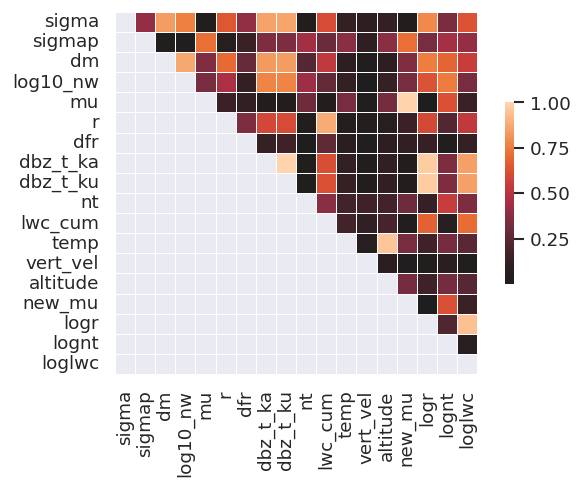

In [139]:
sns.heatmap(upper,center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [140]:
nc = [f'{i}_T' for i in new_df.columns]
nc

['sigma_T',
 'sigmap_T',
 'mu_T',
 'r_T',
 'dfr_T',
 'nt_T',
 'temp_T',
 'vert_vel_T',
 'lognt_T',
 'kmeans_6_T',
 'sigma_T_T',
 'sigmap_T_T',
 'mu_T_T',
 'r_T_T',
 'dfr_T_T',
 'nt_T_T',
 'temp_T_T',
 'vert_vel_T_T',
 'lognt_T_T',
 'kmeans_6_T_T']

In [124]:
scaler = StandardScaler()
new_df[nc]= scaler.fit_transform(new_df)


In [120]:
pca = PCA(0.95)

pca.fit_transform(new_df[nc])
# new_df

array([[-0.5798236 ,  1.33315504,  0.71890954, ..., -1.38870077,
        -1.08096937, -0.25274952],
       [-0.34171244,  2.12535941,  0.04846   , ..., -1.33634104,
        -1.11226689,  0.39966498],
       [-2.48006409, -0.05241676, -0.0042682 , ...,  0.31680777,
        -0.83118704, -0.05513458],
       ...,
       [-2.69603035, -0.0125388 ,  0.08549848, ...,  1.0471866 ,
        -0.89663191,  0.30761307],
       [-1.45897188,  0.41335958,  0.37041318, ...,  0.0263225 ,
        -0.78356224,  0.09896893],
       [-1.00754833, -0.12127946,  0.2353518 , ..., -0.00801545,
        -0.44915131,  0.05510392]])

In [115]:
n_c = 6
X = new_df[[f'PCA{i}' for i in range(1, 7,1)]]
kmeans = KMeans(n_clusters=n_c)
kmeans.fit(X)
new_df['kmeans_6'] = kmeans.labels_

KeyError: "None of [Index(['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7'], dtype='object')] are in the [columns]"

In [116]:
from matplotlib.colors import ListedColormap

# construct cmap
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
my_cmap6 = ListedColormap(sns.color_palette(flatui).as_hex())

colors6 = my_cmap6(np.linspace(0,1,n_c))

In [117]:
sns.set(rc={"figure.dpi":120, 'savefig.dpi':120})

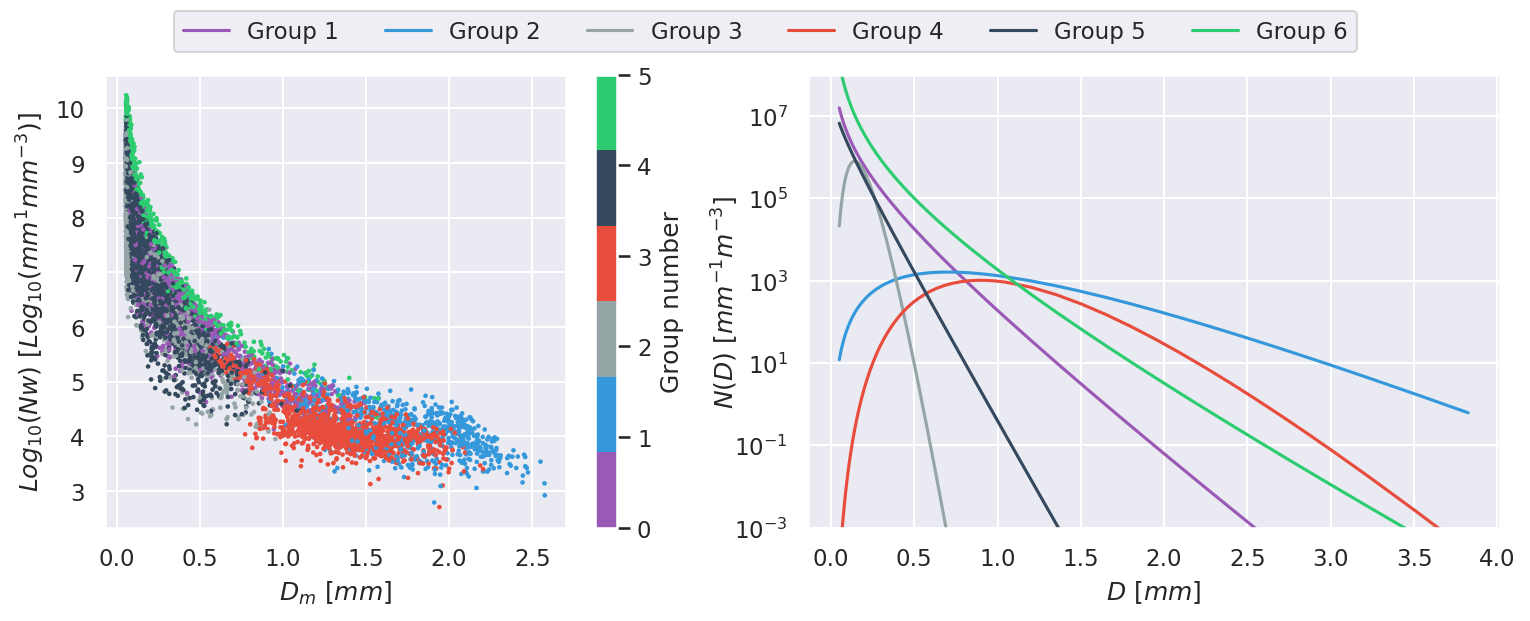

In [118]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12,4), dpi=150,  gridspec_kw={'width_ratios': [1, 1.2]})
sc = ax.scatter(df['dm'], df['log10_nw'], c=df['kmeans_6'], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e8)
d = ds.diameter/1000
ax1.grid('both')
n = df['kmeans_6'].max() + 1
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$", labelpad=-3)
ax1.set_xlabel("$D\ [mm]$")
# colors = pl.cm.jet(np.linspace(0,1,n))
for i in range(0,n):
    df_sub = df[df['kmeans_6'] == i]
    mu = df_sub['mu'].mean()
    dm = df_sub['dm'].mean()
    nw = 10 ** (df_sub['log10_nw'].mean())
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(ds.diameter/1000, gm, c=colors6[i], label=f"Group {i + 1}")
# ax1.legend()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', ncol=6)

In [74]:
tsne = TSNE(n_components=2, random_state=42)
df[['TSNE1', 'TSNE2']] = tsne.fit_transform(X)

In [75]:
X = df[['TSNE1', 'TSNE2']]
kmeans = KMeans(n_clusters=n_c)
kmeans.fit(X)
df['kmeans'] = kmeans.labels_

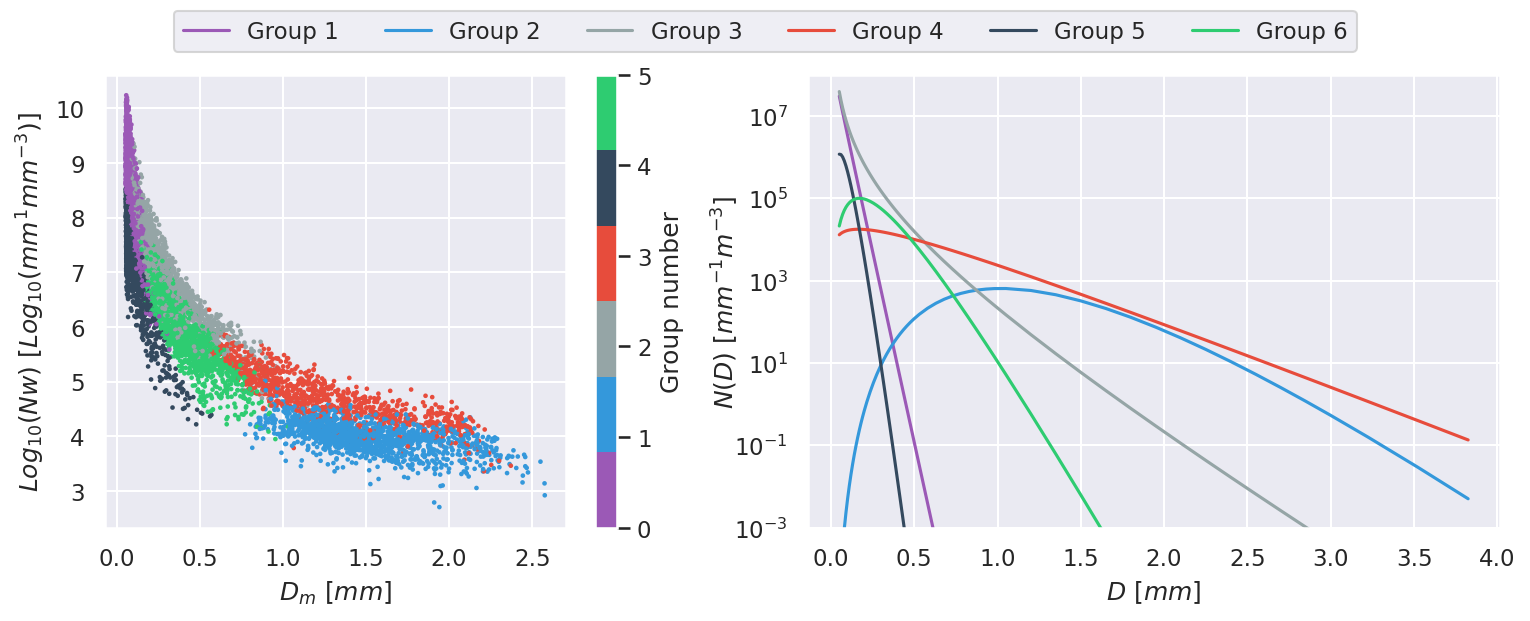

In [76]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12,4), dpi=150,  gridspec_kw={'width_ratios': [1, 1.2]})
sc = ax.scatter(df['dm'], df['log10_nw'], c=df['kmeans'], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e8)
d = ds.diameter/1000
ax1.grid('both')
n = df['kmeans_6'].max() + 1
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$", labelpad=-3)
ax1.set_xlabel("$D\ [mm]$")
# colors = pl.cm.jet(np.linspace(0,1,n))
for i in range(0,n):
    df_sub = df[df['kmeans'] == i]
    mu = df_sub['mu'].mean()
    dm = df_sub['dm'].mean()
    nw = 10 ** (df_sub['log10_nw'].mean())
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(ds.diameter/1000, gm, c=colors6[i], label=f"Group {i + 1}")
# ax1.legend()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', ncol=6)

In [ ]:
fig, ax1 = plt.subplots(figsize=(6,4), dpi=150)
ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e8)
d = ds.diameter/1000
ax1.grid('both')
n = df['kmeans_6'].max() + 1
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$", labelpad=-3)
ax1.set_xlabel("$D\ [mm]$")
# colors = pl.cm.jet(np.linspace(0,1,n))
for i in range(0,n):
    df_sub = df[df['kmeans_6'] == i]
    mu = df_sub['mu'].mean()
    dm = df_sub['dm'].mean()
    nw = 10 ** (df_sub['log10_nw'].mean())
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(ds.diameter/1000, gm, c=colors6[i], label=f"Group {i + 1}")
ax1.legend()

In [ ]:
# df =  df[(df['mu'] < 20)]
labels = ['1', '2', '3', '4', '5', '6']
p = sns.jointplot(data=df.rename(columns={"kmeans_6": "Group"}).replace({i: i + 1 for i in df.rename(columns={"kmeans_6": "Group"})['Group'].unique()}), 
                  x="dm", y="new_mu", kind="kde", hue="Group", palette=sns.color_palette(flatui).as_hex(), 
                  shade=True, alpha=.5,)
p.fig.subplots_adjust(top=0.95)
p.set_axis_labels(r"${D_m [mm]}$", r"${\mu \  [unitless]}$",)
# p.ax_marg_y.set_ylim(-75, 75)
# p._legend.remove()
ax = plt.gca()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter(df.dm, df.sigma, c=df['kmeans_6'], s=1, cmap=my_cmap6)
ax.set_xlabel("Dm \ [mm]")
ax.set_ylabel(r"$\sigma \ [mm] $")

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter(df.dm, df.logr, c=df['kmeans_6'], s=1, cmap=my_cmap6)
ax.set_xlabel("Dm")
ax.set_ylabel(r"$Log_{10}(R) \ [Log_{10}(mm hr^{-1})]$")

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter(df.dm, df.r, c=df['kmeans_6'], s=1, cmap=my_cmap6)
ax.set_xlabel("Dm")
ax.set_ylabel(r"$Log_{10}(R) \ [Log_{10}(mm hr^{-1})]$")
ax.set_yscale('log')
ax.set_ylim(0, 200)

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter(df.dm, df.dbz_t_ka, c=df['kmeans_6'], s=1, cmap=my_cmap6)
ax.set_xlabel("Dm")
ax.set_ylabel(r"$Z_{Ka} \ [dBZ]$")
# ax.set_yscale('log')
ax.set_xscale('log')

# ax.set_ylim(0, 200)

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter(df.dm, df.dbz_t_ku, c=df['kmeans_6'], s=1, cmap=my_cmap6)
ax.set_xlabel("Dm")
ax.set_ylabel(r"$Z_{Ku} \ [dBZ]$")
ax.set_xscale('log')
# ax.set_ylim(0, 200)

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter(df.dm, df.dbz_t_ku - df.dbz_t_ka, c=df['kmeans_6'], s=1, cmap=my_cmap6)
ax.set_xlabel("Dm")
ax.set_ylabel(r"$DFR \ [dBZ]$")
ax.set_xscale('log')
# ax.set_ylim(0, 200)

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter(df.dm, df.lognt, c=df['kmeans_6'], s=1, cmap=my_cmap6)
ax.set_xlabel("Dm")
ax.set_ylabel(r"$Log_{10}(Nt)$")
# ax.set_yscale('log')
# ax.set_ylim(0, 200)

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter( df.dm, df.temp,c=df['kmeans_6'], s=1, cmap=my_cmap6)
ax.set_xlabel("Dm")
ax.set_ylabel(r"$Temp \ [C]$")
# ax.set_yscale('log')
ax.set_ylim(0, 10)

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter(df.dm, df.vert_vel, c=df['kmeans_6'], s=1, cmap=my_cmap6)
ax.set_xlabel("Dm")
ax.set_ylabel(r"$Temp \ [C]$")
# ax.set_yscale('log')
# ax.set_ylim(0, 10)

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter(df.dm, df.altitude, c=df['kmeans_6'], s=1, cmap=my_cmap6)
ax.set_xlabel("Dm")
ax.set_ylabel(r"$Altitude \ [ft]$")
# ax.set_yscale('log')
# ax.set_ylim(0, 10)

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter( df.dm, df.dfr, c=df['kmeans_6'], s=1, cmap=my_cmap6)
ax.set_xlabel("DFR")
ax.set_ylabel(r"$Dm$")
ax.set_xscale('log')
# ax.set_ylim(0, 10)

In [ ]:
def get_kmeans_score(df, center):
    '''
    returns the kmeans score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the kmeans model fit to the data
    '''
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(df)
    model2 = kmeans.fit_predict(df)
    cluster_labels = model.labels_
    
    dav = davies_bouldin_score(df, model2)
    sil = silhouette_score(df, cluster_labels)
    elbow = model.inertia_
    return dav, sil, elbow

dav = []
sil = []
elbow = []


for center in range(2,15):
    _dav, _sil, _el = get_kmeans_score(df[['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]], center)
    dav.append(_dav)
    sil.append(_sil)
    elbow.append(_el)


In [ ]:
centers = range(2,15)
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 3), dpi=150)
ax.plot(centers, dav, linestyle='--', marker='o', color='b');
ax.set_xlabel('K');
ax.set_ylabel('Score');
ax.set_title('Davies Bouldin method');

ax1.plot(centers, sil, linestyle='--', marker='o', color='b');
ax1.set_xlabel('K');
ax1.set_ylabel('Score');
ax1.set_title('silhouette method');

ax2.plot(centers, elbow, linestyle='--', marker='o', color='b');
ax2.set_xlabel('K');
ax2.set_ylabel('Score');
ax2.set_title('Elbow method');

In [ ]:
g1 = df[(df.PCA1 > 1.5) & (df.PCA2 > -1.5)  & (df.PCA2 < 1.5)]
df.loc[(df.PCA1 > 1.5) & (df.PCA2 > -1.5)  & (df.PCA2 < 1.5), 'Group_PCA'] = 1
g2 = df[(df.PCA1 > -4.5) & (df.PCA1 < -1.5)]
df.loc[(df.PCA1 > -4.5) & (df.PCA1 < -1.5), 'Group_PCA'] = 2
g3 = df[(df.PCA2 > 1.5)& (df.PCA1 > -1.5) & (df.PCA1 < 1.5)]
df.loc[(df.PCA2 > 1.5)& (df.PCA1 > -1.5) & (df.PCA1 < 1.5), 'Group_PCA'] = 3
g4 = df[(df.PCA2 < -1.5)& (df.PCA1 > -1.5) & (df.PCA1 < 1.5)]
df.loc[(df.PCA2 < -1.5)& (df.PCA1 > -1.5) & (df.PCA1 < 1.5), 'Group_PCA'] = 4
g5 = df[(df.PCA2 > 1.5)& (df.PCA1 > 1.5)]
df.loc[(df.PCA2 > 1.5)& (df.PCA1 > 1.5), 'Group_PCA'] = 5
g6 = df[(df.PCA2 < -1.5)& (df.PCA1 > 1.5)]
df.loc[(df.PCA2 < -1.5)& (df.PCA1 > 1.5), 'Group_PCA'] = 6
gn = df[(df.PCA2 > -1.5) & (df.PCA2 < 1.5) & (df.PCA1 > -1.5) & (df.PCA1 < 1.5)]
df.loc[(df.PCA2 > -1.5) & (df.PCA2 < 1.5) & (df.PCA1 > -1.5) & (df.PCA1 < 1.5), 'Group_PCA'] = 7

In [ ]:
ls_gr = [g1, g2, g3, g4, g5, g6]

In [ ]:
d = ds.diameter / 1000
dm1, mu1, nw1 = g1['dm'].mean(), g1['mu'].mean(), 10 ** (g1['log10_nw']).mean()
gm1 = norm_gamma(d, nw=nw1, mu=mu1, dm=dm1)

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10,4), dpi=150, gridspec_kw={'width_ratios': [1, 1.5]})
ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e8)
ax1.grid('both')
n = len(ls_gr)
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$", labelpad=-2)
ax1.set_xlabel("$D\ [mm]$")
for idx, i in enumerate(ls_gr):
    dm, mu, nw = i['dm'].mean(), i['mu'].mean(), 10 ** (i['log10_nw']).mean()
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(d, gm, c=colors6[idx], label=f"Group {idx + 1}")
# ax1.legend()

ax.scatter(df.PCA1, df.PCA2, s=1, zorder=10, c='k')
ax.axvline(x=0, ls="--", c='grey', lw=1.5)
ax.axvline(x=1.5, ls="--",  c='grey', lw=1.5)
ax.axvline(x=-1.5, ls="--",  c='grey', lw=1.5)
ax.axhline(y=0, ls="--",  c='grey', lw=1.5)
ax.axhline(y=1.5, ls="--",  c='grey', lw=1.5)
ax.axhline(y=-1.5, ls="--",  c='grey', lw=1.5)

# group 1
rect = plt.Rectangle((1.5,-1.5), 4.5, 3,
                     facecolor=colors6[0], alpha=0.5, zorder=10)
ax.add_patch(rect)

# group 2
rect5 = plt.Rectangle((-4.5, -4.5), 3, 10,
                     facecolor=colors6[1], alpha=0.5, zorder=10)
ax.add_patch(rect5)

# group 3
rect4 = plt.Rectangle((-1.5, 1.5), 3, 3,
                     facecolor=colors6[2], alpha=0.5, zorder=10)

ax.add_patch(rect4)

# group 4
rect3 = plt.Rectangle((-1.5,-4.5), 3, 3,
                     facecolor=colors6[3], alpha=0.5, zorder=10)
ax.add_patch(rect3)

# group 5
rect1 = plt.Rectangle((1.5,1.5), 3.5, 3,
                     facecolor=colors6[4], alpha=0.5, zorder=10)
ax.add_patch(rect1)

#group 6
rect2 = plt.Rectangle((1.5,-4.5), 3.5, 3,
                     facecolor=colors6[5], alpha=0.5, zorder=10)
ax.add_patch(rect2)

ax.set_xlabel(r"$PCA \ 1 \ [Std. \ Anomaly]$")
ax.set_ylabel(r"$PCA \ 2 \ [Std. \ Anomaly]$")
ax.set_ylim(-4.5, 4.5)
ax.set_xlim(-4.5, 4.5)
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', ncol=6)
# fig.tight_layout()

In [ ]:
fig, ax1 = plt.subplots(figsize=(6,4), dpi=150)
ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e8)
ax1.grid('both')
n = len(ls_gr)
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$", labelpad=-2)
ax1.set_xlabel("$D\ [mm]$")
for idx, i in enumerate(ls_gr):
    dm, mu, nw = i['dm'].mean(), i['mu'].mean(), 10 ** (i['log10_nw']).mean()
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(d, gm, c=colors6[idx], label=f"Group {idx + 1}")
ax1.legend()

In [ ]:
from matplotlib.colors import ListedColormap

# construct cmap
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", "#FFFF00"]
my_cmap7 = ListedColormap(sns.color_palette(flatui).as_hex())
n=7
colors7 = my_cmap7(np.linspace(0,1,n))

In [ ]:
labels = ['1', '2', '3', '4', '5', '6', "7"]
p = sns.jointplot(data=df, 
                  x="dm", y="new_mu", kind="kde", hue="Group_PCA", palette=sns.color_palette(flatui).as_hex(), 
                  shade=True, alpha=.5,)
p.fig.subplots_adjust(top=0.95)
p.set_axis_labels(r"${D_m [mm]}$", r"${\mu \  [unitless]}$",)
# p.ax_marg_y.set_ylim(-75, 75)
# p._legend.remove()
ax = plt.gca()
plt.show()

In [ ]:
fig,  ax = plt.subplots(figsize=(5,4), dpi=150)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df["Group_PCA"], s=1.5, cmap=my_cmap7)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")



In [ ]:
from sklearn.cluster import Birch, DBSCAN, MiniBatchKMeans, MeanShift, OPTICS, SpectralClustering

In [ ]:
model = Birch(threshold=0.01, n_clusters=6)
model.fit(X)

In [ ]:
df['birch_g'] = model.predict(X)

In [ ]:
silhouette_score(X, df['birch_g'])

In [ ]:
fig,  ax = plt.subplots(figsize=(5,4), dpi=150)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df["birch_g"], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")


In [ ]:
model = DBSCAN(eps=0.30, min_samples=9)
# fit model and predict clusters
df['dbscan_g'] = model.fit_predict(X)

In [ ]:
fig,  ax = plt.subplots(figsize=(5,4), dpi=150)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df["dbscan_g"], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

In [ ]:
model = MiniBatchKMeans(n_clusters=6)
# fit the model
model.fit(X)
df['Mb_kmeans'] = model.predict(X)

In [ ]:
davies_bouldin_score(X, df['Mb_kmeans'])
silhouette_score(X, df['Mb_kmeans'])

In [ ]:
fig,  ax = plt.subplots(figsize=(5,4), dpi=150)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df["Mb_kmeans"], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

In [ ]:
model = MeanShift()
# fit model and predict clusters
df['mean_shift'] = model.fit_predict(X)

In [ ]:
davies_bouldin_score(X, df['mean_shift'])

In [ ]:
fig,  ax = plt.subplots(figsize=(5,4), dpi=150)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df["mean_shift"], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

In [ ]:
model = OPTICS(eps=0.8, min_samples=10)
# fit model and predict clusters
df['optics']= model.fit_predict(X)

In [ ]:
fig,  ax = plt.subplots(figsize=(5,4), dpi=150)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df["optics"], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

In [ ]:
model = SpectralClustering(n_clusters=6)
# fit model and predict clusters
df['spectral'] = model.fit_predict(X)
# retrieve unique clusters


In [ ]:
fig,  ax = plt.subplots(figsize=(5,4), dpi=150)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df["spectral"], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
model = GaussianMixture(n_components=6)
# fit the model
model.fit(X)
# assign a cluster to each example
df['gaussian'] = model.predict(X)

In [ ]:
fig,  ax = plt.subplots(figsize=(5,4), dpi=150)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df["gaussian"], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=3, random_state=42)
df[['TSNE1', 'TSNE2', "TSNE3"]] = tsne.fit_transform(X)
tsne.kl_divergence_

In [ ]:
import plotly.express as px
fig = px.scatter_3d(df, x='TSNE1', y='TSNE2', z='TSNE3',
              color='spectral', width=800, height=800)
fig.update_traces(marker_size = 4)
fig.show()

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
df[['tsne1', 'tsne2']] = tsne.fit_transform(X)
tsne.kl_divergence_

In [ ]:

fig,  ax = plt.subplots(figsize=(5,4), dpi=150)
sc = ax.scatter(df['tsne1'], df['tsne2'], c=df['spectral'], s=1, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

In [ ]:
pca = PCA(0.95)
df[['pca1', 'pca2', "pca3"]]  = pca.fit_transform(X)

In [ ]:
import plotly.express as px
fig = px.scatter_3d(df, x='pca1', y='pca2', z='pca3',
              color='kmeans_6', width=800, height=800, color_discrete_map=my_cmap6)
fig.update_traces(marker_size = 4)
fig.show()

In [ ]:
import plotly.express as px
fig = px.scatter_3d(df, x='dm', y='log10_nw', z='lwc_cum',
              color='kmeans_6', width=800, height=800)
fig.update_traces(marker_size = 4)
fig.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
model = AgglomerativeClustering(n_clusters=6).fit(X)

In [ ]:
df['agg_clus'] = model.labels_

In [ ]:
fig,  ax = plt.subplots(figsize=(5,4), dpi=150)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df["agg_clus"], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")